# Uncertainty analysis - Pancreas

## Library imports

In [1]:
from typing import List
import os
import sys

import numpy as np
import pandas as pd
import torch
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from statannotations.Annotator import Annotator

import scanpy as sc
import scvelo as scv
import scvi
from scvelo.plotting.simulation import compute_dynamics
from velovi import preprocess_data, VELOVI
from velovi._model import _compute_directional_statistics_tensor

sys.path.append("../..")
from paths import DATA_DIR, FIG_DIR

Global seed set to 0
/home/adam/miniconda3/envs/velovi/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/adam/miniconda3/envs/velovi/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## General settings

In [2]:
scvi.settings.dl_pin_memory_gpu_training = False

In [3]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'uncertainty' / 'pancreas_noise', exist_ok=True)

## Function definition

In [5]:
def fit_velovi(bdata):
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)

    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return vae

In [6]:
def plot_phase_portrait(adata, gene, color, figsize=(6, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    df = pd.DataFrame(
        {
            'unspliced': adata[:, gene].layers['Mu'].squeeze().copy(),
            'spliced': adata[:, gene].layers['Ms'].squeeze().copy(),
            'color': color
        }
    )

    with mplscience.style_context():
        sns.scatterplot(data=df, x='spliced', y='unspliced', c=color, s=25, ax=ax);

        _, unspliced, spliced = compute_dynamics(adata, basis=gene, extrapolate=True, sort=True)
        df = pd.DataFrame(
            {
                'unspliced': unspliced.squeeze(),
                'spliced': spliced.squeeze(),
            }
        )

        ax.plot(spliced, unspliced, color="purple", linewidth=2)

        spliced_steady_state = np.linspace(np.min(spliced), np.max(spliced))
        unspliced_steady_state = adata.var.loc[gene, 'fit_gamma'] / adata.var.loc[gene, 'fit_beta'] * (spliced_steady_state - np.min(spliced_steady_state)) + np.min(unspliced)
        ax.plot(spliced_steady_state, unspliced_steady_state, color='purple', linestyle="--", linewidth=2);

    ax.axis('off')
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'uncertainty' / 'pancreas' / f'phase_portrait_{gene}.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )

In [7]:
def compute_extrinisic_uncertainty(adata, vae, n_samples=25) -> pd.DataFrame:
    from velovi._model import _compute_directional_statistics_tensor
    from scvi.utils import track
    from contextlib import redirect_stdout
    import io

    extrapolated_cells_list = []
    for i in track(range(n_samples)):
        with io.StringIO() as buf, redirect_stdout(buf):
            vkey = "velocities_velovi_{i}".format(i=i)
            v = vae.get_velocity(n_samples=1, velo_statistic="mean")
            adata.layers[vkey] = v
            scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=False, approx=True)
            t_mat = scv.utils.get_transition_matrix(
                adata, vkey=vkey, self_transitions=True, use_negative_cosines=True
            )
            extrapolated_cells = np.asarray(t_mat @ adata.layers["Ms"])
            extrapolated_cells_list.append(extrapolated_cells)
    extrapolated_cells = np.stack(extrapolated_cells_list)
    df, _ = _compute_directional_statistics_tensor(extrapolated_cells, n_jobs=-1, n_cells=adata.n_obs)
    return df.directional_cosine_sim_variance

In [8]:
def downsample_cells(adata: sc.AnnData, frac: float, genes_to_use: List[str]) -> sc.AnnData:
    """Downsample cells' counts.
    
    Frac is frac of observed library size to downsample to.
    """
    from scanpy.preprocessing._simple import _downsample_per_cell
    adata = adata.copy()
    random_state = 0
    replace = False
    for key in ["spliced", "unspliced", "X"]:
        mat = adata.layers[key] if key != "X" else adata.X
        counts_per_cell = np.asarray(mat.sum(axis=1)).flatten()
        counts_per_cell = np.ceil(counts_per_cell * frac)
        mat = _downsample_per_cell(mat, counts_per_cell, random_state, replace)
        if key != "X":
            adata.layers[key] = mat
        else:
            adata.X = mat
    scv.pp.filter_and_normalize(adata)
    adata = adata[:, genes_to_use].copy()
    sc.tl.pca(adata)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    return adata


In [9]:
def dropout_unspliced_gene(adata: sc.AnnData, num_genes: int, frac: float, genes_to_use: List[str]) -> sc.AnnData:
    """Downsample cells' counts."""
    adata = adata.copy()
    key = "unspliced"
    mat = adata.layers[key]
    # Use the same genes for each call with the same num_genes
    random_state = np.random.RandomState(0)
    gene_idx = random_state.choice(np.arange(len(genes_to_use)), size=num_genes, replace=False)
    gene_idx = np.isin(adata.var_names, genes_to_use[gene_idx])
    adata.layers[key] = mat
    # adata.layers[key][:, gene_idx]  = np.rint(frac * adata.layers[key][:, gene_idx])
    adata.layers[key][:, gene_idx]  = csr_matrix(np.random.binomial(adata.layers[key][:, gene_idx].A.astype(np.int64), frac).astype(np.float32))
    scv.pp.filter_and_normalize(adata)
    adata.var["scaled_gene"] = False
    adata.var.loc[adata.var_names[gene_idx], "scaled_gene"] = True
    adata = adata[:, genes_to_use].copy()
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    return adata


In [10]:
def keep_fraction_of_celltype(adata: sc.AnnData, labels_key: str, category: str, frac: float, genes_to_use: List[str]) -> sc.AnnData:
    """Keep fraction of cells from cell type."""
    adata = adata.copy()
    idx = np.where(adata.obs[labels_key] == category)[0]
    remove_subset_ct = np.random.choice(idx, size=int((1-frac) * len(idx)), replace=False)
    cur_inds = np.arange(adata.shape[0])
    new_inds = np.delete(cur_inds, remove_subset_ct)
    adata = adata[new_inds].copy()
    scv.pp.filter_and_normalize(adata)
    adata = adata[:, genes_to_use].copy()
    sc.tl.pca(adata)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    return adata

In [11]:
def add_noise_to_celltype(adata: sc.AnnData, labels_key: str, category: str, sigma: float, gene_mask=None, genes_to_use: List[str] = None) -> sc.AnnData:
    """Add multiplicative noise to a cell type."""
    adata = adata.copy()
    idx = adata.obs[labels_key] == category
    noise_ms = np.exp(np.random.normal(0, sigma, size=adata[idx].X.shape))
    noise_mu = np.exp(np.random.normal(0, sigma, size=adata[idx].X.shape))
    if gene_mask is not None:
        noise_ms[:, ~gene_mask] = 1
        noise_mu[:, ~gene_mask] = 1
    scv.pp.filter_and_normalize(adata)
    adata.layers["spliced"] = adata.layers["spliced"].A
    adata.layers["unspliced"] = adata.layers["unspliced"].A
    adata.layers["spliced"][idx] *= noise_ms
    adata.layers["unspliced"][idx] *= noise_mu
    # X is same as spliced, but log1pd
    adata.X = np.log1p(adata.layers["spliced"])
    adata.layers["spliced"] = adata.layers["spliced"]
    adata.layers["unspliced"] = adata.layers["unspliced"]
    adata = adata[:, genes_to_use].copy()
    sc.tl.pca(adata)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    return adata

## Data loading

In [12]:
adata = scv.datasets.pancreas(DATA_DIR / "pancreas" / "endocrinogenesis_day15.h5ad")

# Find a universal gene set
bdata = adata.copy()
scv.pp.filter_and_normalize(bdata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(bdata, n_pcs=30, n_neighbors=30)
bdata = preprocess_data(bdata)
genes_to_use = bdata.var_names

adata

Filtered out 21611 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

## UMI Downsampling

In [13]:
adata = scv.datasets.pancreas(DATA_DIR / "pancreas" / "endocrinogenesis_day15.h5ad")

In [14]:
uncertainty_full_df = pd.DataFrame(columns=["Uncertainty", "Fraction removed", "Type"])
perturbed_adatas = {}
fracs = [1, 0.75, 0.5, 0.25]
for s in fracs:
    if s != 0 or s != 1:
        bdata = downsample_cells(adata, s, genes_to_use=genes_to_use)
    else:
        bdata = adata.copy()
    bdata = preprocess_data(bdata, min_max_scale=True, filter_on_r2=False)
    perturbed_adatas[s] = bdata
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")
    vae = VELOVI(bdata)
    vae.train()
    uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=100)
    extrinsic = np.log10(compute_extrinisic_uncertainty(bdata, vae, n_samples=25))
    intrinsic = np.log10(uncertainty_df.directional_cosine_sim_variance)
    unc_type = ["Intrinsic"] * len(intrinsic) + ["Extrinsic"] * len(extrinsic)
    df = pd.DataFrame()
    df["Uncertainty"] = np.concatenate([intrinsic, extrinsic])
    df["Fraction removed"] = [1-s] * len(df)
    df["Type"] = unc_type
    uncertainty_full_df = pd.concat([uncertainty_full_df, df])

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 496/500:  99%|█████████▉| 496/500 [01:28<00:00,  5.61it/s, loss=-2.41e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2328.608. Signaling Trainer to stop.
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
/home/adam/miniconda3/envs/velovi/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/adam/miniconda3/envs/velovi/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7

Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:05<02:02,  5.09s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:10<01:58,  5.14s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:13<01:38,  4.47s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:18<01:38,  4.70s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:24<01:36,  4.84s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:29<01:33,  4.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:34<01:29,  4.95s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:39<01:24,  5.00s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:43<01:16,  4.78s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:48<01:13,  4.89s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [00:53<01:09,  4.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [00:58<01:03,  4.88s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:03<00:58,  4.90s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:08<00:54,  4.97s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:13<00:50,  5.00s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:18<00:45,  5.03s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [01:23<00:39,  5.00s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [01:28<00:33,  4.84s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [01:33<00:29,  4.93s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [01:38<00:24,  4.99s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [01:43<00:20,  5.01s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [01:48<00:15,  5.09s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [01:53<00:09,  4.85s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [01:56<00:04,  4.49s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [02:01<00:00,  4.87s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2344 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.8s finished


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 412/500:  82%|████████▏ | 412/500 [01:12<00:15,  5.69it/s, loss=-2.47e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2379.069. Signaling Trainer to stop.
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 3612 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    2.9s finished


Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:05<02:07,  5.30s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:10<01:58,  5.17s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:13<01:37,  4.41s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:19<01:39,  4.72s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:24<01:37,  4.87s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:29<01:33,  4.93s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:34<01:29,  4.99s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:39<01:25,  5.03s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:44<01:19,  4.95s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:49<01:14,  4.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [00:54<01:09,  4.98s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [00:59<01:03,  4.91s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:04<00:59,  4.98s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:09<00:54,  4.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:13<00:49,  4.95s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:18<00:43,  4.78s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [01:23<00:38,  4.82s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [01:28<00:34,  4.92s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [01:33<00:29,  4.99s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [01:38<00:24,  4.97s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [01:43<00:19,  4.92s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [01:48<00:14,  4.89s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [01:53<00:09,  4.90s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [01:57<00:04,  4.85s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [02:02<00:00,  4.92s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2371 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.8s finished


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 371/500:  74%|███████▍  | 371/500 [01:04<00:22,  5.74it/s, loss=-2.61e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2486.928. Signaling Trainer to stop.
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 3597 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    2.9s finished


Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:06<02:29,  6.25s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:12<02:25,  6.33s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:19<02:20,  6.39s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:25<02:13,  6.38s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:31<02:07,  6.35s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:38<02:01,  6.37s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:44<01:55,  6.41s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:49<01:41,  5.97s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:56<01:37,  6.09s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [01:02<01:32,  6.20s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [01:08<01:27,  6.24s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [01:14<01:19,  6.10s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:20<01:13,  6.15s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:27<01:08,  6.24s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:32<00:59,  5.99s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:37<00:51,  5.75s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [01:43<00:45,  5.71s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [01:47<00:37,  5.33s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [01:54<00:33,  5.63s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [02:00<00:28,  5.73s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [02:06<00:24,  6.00s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [02:13<00:18,  6.07s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [02:18<00:11,  5.93s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [02:25<00:06,  6.07s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [02:31<00:00,  6.07s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2398 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.8s finished


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 186/500:  37%|███▋      | 186/500 [00:32<00:55,  5.65it/s, loss=-2.99e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2793.657. Signaling Trainer to stop.
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 3612 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    2.9s finished


Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:05<02:23,  5.98s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:11<02:16,  5.95s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:18<02:13,  6.07s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:23<02:05,  5.96s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:30<02:00,  6.04s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:32<01:31,  4.81s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:38<01:32,  5.15s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:44<01:34,  5.55s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:51<01:32,  5.81s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:57<01:29,  5.98s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [01:00<01:11,  5.12s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [01:06<01:08,  5.23s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:12<01:08,  5.69s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:18<01:02,  5.66s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:22<00:50,  5.05s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:27<00:45,  5.01s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [01:32<00:42,  5.25s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [01:39<00:38,  5.55s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [01:45<00:35,  5.90s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [01:52<00:30,  6.17s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [01:59<00:25,  6.28s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [02:05<00:18,  6.20s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [02:10<00:12,  6.01s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [02:16<00:06,  6.07s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [02:22<00:00,  5.68s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2344 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.8s finished


### Plot

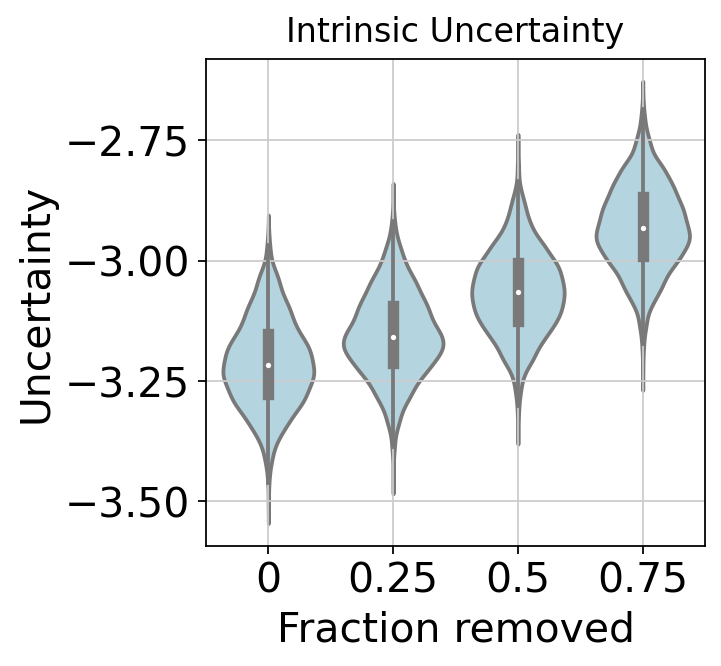

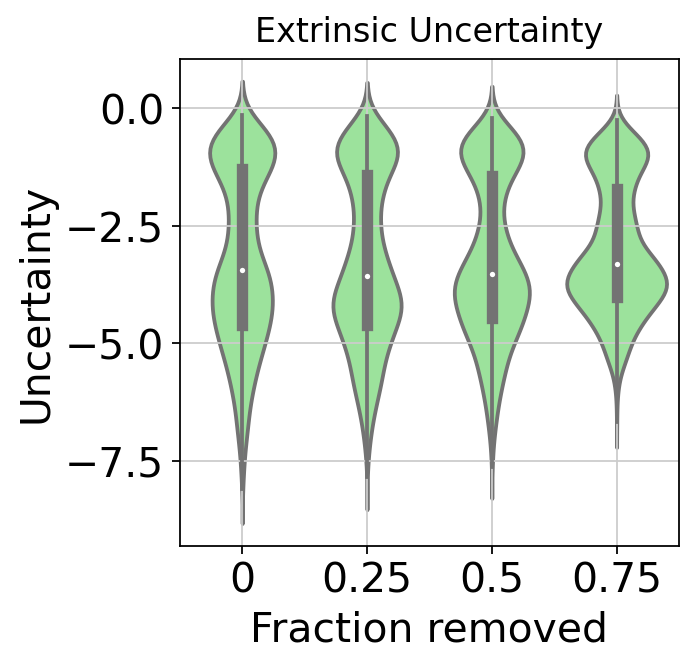

In [15]:
pairs= [(0, 0.25), (0.25, 0.5),(0.5, 0.75)]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
with mplscience.style_context():
    x = "Fraction removed"
    y = "Uncertainty"
    df = uncertainty_full_df.query("Type == 'Intrinsic'")
    sns.violinplot(x=x, y=y, data=df, color="lightblue", ax=ax)
    plt.title("Intrinsic Uncertainty")
    # annotator = Annotator(ax, pairs, data=df, x=x, y=y)
    # annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
    # annotator.apply_and_annotate()
    ax.grid()

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'uncertainty' / 'pancreas_noise' / 'intrinsic_downsampling.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )    

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
with mplscience.style_context():
    df = uncertainty_full_df.query("Type == 'Extrinsic'")
    sns.violinplot(x=x, y=y, data=df, color="lightgreen", ax=ax)
    plt.title("Extrinsic Uncertainty")
    # annotator = Annotator(ax, pairs, data=df, x=x, y=y)
    # annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
    # annotator.apply_and_annotate()
    ax.grid()

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'uncertainty' / 'pancreas_noise' / 'extrinsic_downsampling.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )    


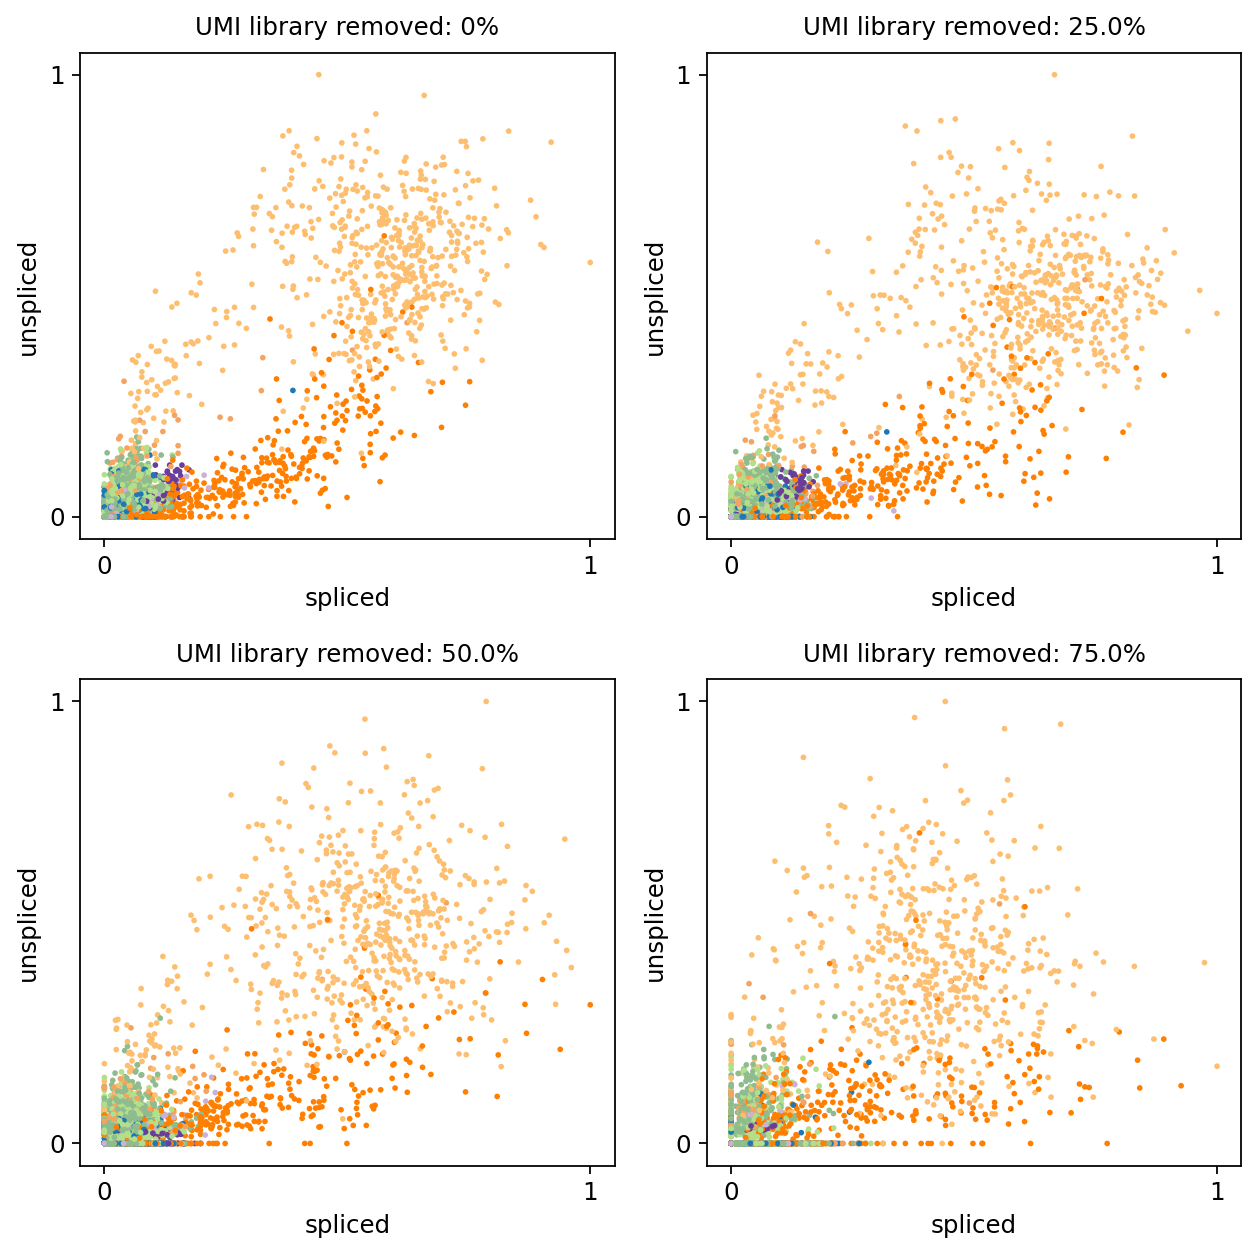

In [16]:
g = "Sulf2"
fig, axarr = plt.subplots(2, 2, figsize=(8, 8))
with mplscience.style_context():
    for (s, ad), ax in zip(perturbed_adatas.items(), axarr.flat):
        scv.pl.scatter(ad, basis=g, title=f"UMI library removed: {(1 - s) * 100}%", ax=ax, show=False)
    plt.tight_layout()

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'uncertainty' / 'pancreas_noise' / 'genes_downsampling.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )    



## Unspliced dropout

In [17]:
adata = scv.datasets.pancreas(DATA_DIR / "pancreas" / "endocrinogenesis_day15.h5ad")

In [18]:
uncertainty_full_df = pd.DataFrame(columns=["Uncertainty", "Dropout probability", "Type", "Num genes"])
perturbed_adatas = {}
fracs = [1, 0.5, 0.1, 0.02]
n_genes = [400, 800]

for g in n_genes:
    for s in fracs:
        if s != 0 or s != 1:
            bdata = dropout_unspliced_gene(adata, g, s, genes_to_use=genes_to_use)
        else:
            bdata = adata.copy()
        bdata = preprocess_data(bdata, min_max_scale=True, filter_on_r2=False)
        perturbed_adatas[(s, g)] = bdata
        VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")
        vae = VELOVI(bdata)
        vae.train()
        uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=100)
        extrinsic = np.log10(compute_extrinisic_uncertainty(bdata, vae, n_samples=25))
        intrinsic = np.log10(uncertainty_df.directional_cosine_sim_variance)
        unc_type = ["Intrinsic"] * len(intrinsic) 
        unc_type += ["Extrinsic"] * len(extrinsic)
        df = pd.DataFrame()
        df["Uncertainty"] = np.concatenate([intrinsic, extrinsic])
        df["Dropout probability"] = [1-s] * len(df)
        df["Type"] = unc_type
        df["Num genes"] = [g] * len(df)
        uncertainty_full_df = pd.concat([uncertainty_full_df, df])

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 485/500:  97%|█████████▋| 485/500 [01:27<00:02,  5.56it/s, loss=-2.41e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2342.135. Signaling Trainer to stop.
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 3612 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    3.0s finished


Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:05<02:09,  5.40s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:10<01:59,  5.20s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:15<01:55,  5.26s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:20<01:48,  5.16s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:26<01:43,  5.19s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:31<01:38,  5.17s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:36<01:32,  5.16s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:41<01:26,  5.10s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:46<01:22,  5.16s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:51<01:16,  5.09s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [00:56<01:12,  5.15s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [01:01<01:06,  5.14s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:03<00:49,  4.16s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:08<00:49,  4.47s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:14<00:46,  4.69s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:19<00:43,  4.82s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [01:24<00:38,  4.81s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [01:29<00:33,  4.84s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [01:34<00:29,  4.93s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [01:39<00:24,  4.96s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [01:44<00:19,  4.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [01:49<00:14,  4.95s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [01:54<00:10,  5.03s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [01:59<00:05,  5.06s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [02:04<00:00,  4.98s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2398 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.9s finished


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [01:29<00:00,  5.58it/s, loss=-2.48e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [01:29<00:00,  5.57it/s, loss=-2.48e+03, v_num=1]
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 3612 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    2.9s finished


Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:05<02:05,  5.21s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:09<01:52,  4.87s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:14<01:41,  4.62s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:19<01:38,  4.71s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:24<01:37,  4.88s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:28<01:31,  4.80s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:33<01:28,  4.90s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:39<01:25,  5.02s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:43<01:19,  4.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:49<01:14,  4.99s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [00:53<01:09,  4.96s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [00:59<01:05,  5.02s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:04<01:00,  5.04s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:09<00:56,  5.13s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:14<00:49,  4.96s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:15<00:36,  4.01s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [01:18<00:28,  3.55s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [01:23<00:27,  3.92s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [01:28<00:25,  4.28s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [01:33<00:22,  4.53s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [01:35<00:15,  3.88s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [01:40<00:12,  4.14s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [01:45<00:08,  4.30s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [01:50<00:04,  4.52s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [01:55<00:00,  4.62s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2371 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.9s finished


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 455/500:  91%|█████████ | 455/500 [01:18<00:07,  5.77it/s, loss=-2.78e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2630.267. Signaling Trainer to stop.
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 3612 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    2.9s finished


Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:05<02:08,  5.36s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:10<01:59,  5.20s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:15<01:53,  5.18s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:20<01:50,  5.26s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:23<01:27,  4.39s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:28<01:27,  4.62s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:34<01:26,  4.79s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:38<01:22,  4.83s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:43<01:17,  4.86s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:49<01:14,  4.96s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [00:54<01:10,  5.04s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [00:59<01:04,  4.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:04<01:00,  5.02s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:09<00:56,  5.17s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:14<00:51,  5.13s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:19<00:46,  5.16s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [01:25<00:41,  5.16s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [01:29<00:34,  4.95s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [01:34<00:30,  5.04s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [01:40<00:25,  5.08s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [01:44<00:20,  5.05s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [01:50<00:15,  5.12s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [01:55<00:10,  5.10s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [02:00<00:05,  5.11s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [02:04<00:00,  4.99s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2371 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.9s finished


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [01:28<00:00,  5.65it/s, loss=-3.28e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [01:28<00:00,  5.63it/s, loss=-3.28e+03, v_num=1]
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 3612 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    2.9s finished


Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:04<01:58,  4.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:10<01:56,  5.05s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:15<01:52,  5.12s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:20<01:45,  5.04s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:24<01:38,  4.93s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:30<01:35,  5.00s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:35<01:31,  5.10s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:40<01:26,  5.08s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:45<01:21,  5.07s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:50<01:16,  5.12s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [00:54<01:08,  4.87s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [00:59<01:03,  4.91s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:05<00:59,  4.98s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:10<00:55,  5.06s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:15<00:50,  5.08s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:20<00:44,  4.99s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [01:23<00:36,  4.54s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [01:29<00:33,  4.80s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [01:34<00:29,  4.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [01:39<00:25,  5.02s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [01:44<00:20,  5.03s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [01:48<00:14,  4.79s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [01:54<00:09,  4.96s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [01:59<00:04,  4.96s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [02:04<00:00,  4.96s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2398 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.8s finished


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 341/500:  68%|██████▊   | 341/500 [01:00<00:28,  5.65it/s, loss=-2.39e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2320.523. Signaling Trainer to stop.
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 3612 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    3.1s finished


Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:05<02:04,  5.21s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:10<02:00,  5.22s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:15<01:54,  5.22s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:20<01:49,  5.23s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:26<01:44,  5.22s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:31<01:37,  5.12s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:36<01:34,  5.22s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:41<01:25,  5.05s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:46<01:21,  5.12s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:51<01:18,  5.21s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [00:56<01:11,  5.14s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [01:01<01:06,  5.13s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:05<00:57,  4.76s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:10<00:52,  4.76s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:15<00:49,  4.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:21<00:45,  5.06s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [01:24<00:35,  4.39s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [01:29<00:31,  4.54s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [01:34<00:28,  4.78s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [01:39<00:23,  4.75s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [01:44<00:19,  4.84s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [01:49<00:14,  4.91s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [01:54<00:09,  4.99s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [01:59<00:04,  4.99s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [02:04<00:00,  4.98s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2371 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.9s finished


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [01:30<00:00,  5.43it/s, loss=-2.54e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [01:30<00:00,  5.50it/s, loss=-2.54e+03, v_num=1]
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 3612 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    2.9s finished


Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:05<02:06,  5.26s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:10<02:00,  5.22s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:15<01:55,  5.26s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:20<01:48,  5.19s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:25<01:42,  5.13s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:30<01:36,  5.10s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:35<01:31,  5.06s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:41<01:27,  5.17s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:46<01:22,  5.15s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:51<01:15,  5.06s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [00:56<01:11,  5.11s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [01:01<01:06,  5.14s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:06<00:59,  4.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:11<00:55,  5.06s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:16<00:50,  5.05s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:21<00:44,  4.99s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [01:26<00:40,  5.05s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [01:31<00:35,  5.12s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [01:36<00:29,  4.89s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [01:41<00:24,  5.00s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [01:46<00:19,  4.99s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [01:51<00:15,  5.06s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [01:55<00:09,  4.77s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [02:00<00:04,  4.86s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [02:04<00:00,  4.99s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2371 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.9s finished


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 359/500:  72%|███████▏  | 359/500 [01:06<00:26,  5.41it/s, loss=-3.11e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2891.805. Signaling Trainer to stop.
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 3612 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    2.9s finished


Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:05<02:08,  5.37s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:07<01:25,  3.71s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:13<01:37,  4.44s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:18<01:40,  4.79s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:21<01:25,  4.26s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:27<01:26,  4.57s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:32<01:25,  4.78s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:37<01:24,  4.96s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:42<01:21,  5.08s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:48<01:16,  5.11s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [00:53<01:11,  5.12s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [00:58<01:07,  5.15s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:03<01:01,  5.16s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:08<00:56,  5.11s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:13<00:49,  4.95s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:18<00:45,  5.11s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [01:24<00:41,  5.16s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [01:29<00:36,  5.17s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [01:34<00:30,  5.10s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [01:39<00:25,  5.08s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [01:44<00:20,  5.09s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [01:49<00:15,  5.11s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [01:54<00:10,  5.05s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [01:56<00:04,  4.14s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [02:01<00:00,  4.86s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2371 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.9s finished


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 340/500:  68%|██████▊   | 340/500 [01:01<00:29,  5.49it/s, loss=-3.99e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -3599.325. Signaling Trainer to stop.
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 3612 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    2.8s finished


Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:02<00:57,  2.42s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:07<01:33,  4.05s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:12<01:39,  4.54s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:17<01:38,  4.69s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:21<01:31,  4.56s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:27<01:30,  4.75s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:32<01:27,  4.88s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:37<01:25,  5.04s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:42<01:20,  5.05s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:47<01:15,  5.05s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [00:52<01:11,  5.09s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [00:58<01:06,  5.11s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:03<01:02,  5.18s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:08<00:56,  5.14s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:12<00:47,  4.71s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:17<00:42,  4.77s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [01:21<00:38,  4.79s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [01:25<00:31,  4.50s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [01:30<00:28,  4.70s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [01:35<00:23,  4.67s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [01:40<00:18,  4.65s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [01:45<00:14,  4.77s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [01:50<00:09,  4.95s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [01:55<00:04,  4.85s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [01:58<00:00,  4.75s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2371 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.9s finished


### Plot

/home/adam/miniconda3/envs/velovi/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/adam/miniconda3/envs/velovi/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/adam/miniconda3/envs/velovi/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/adam/miniconda3/envs/velovi/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


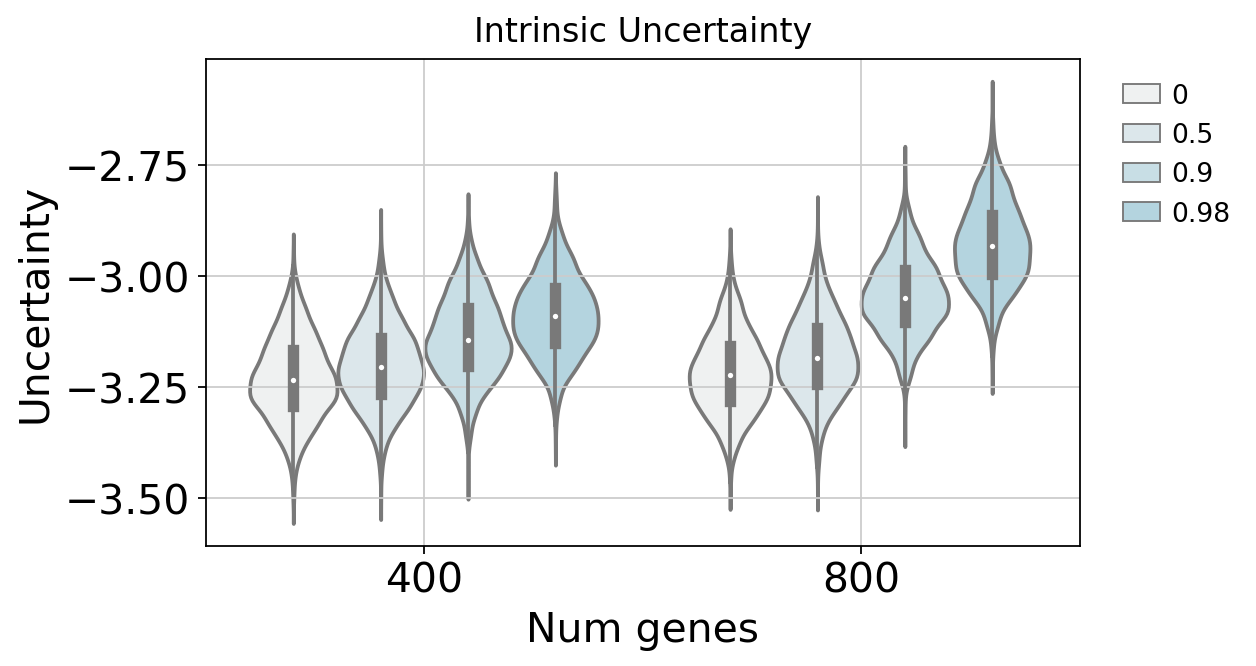

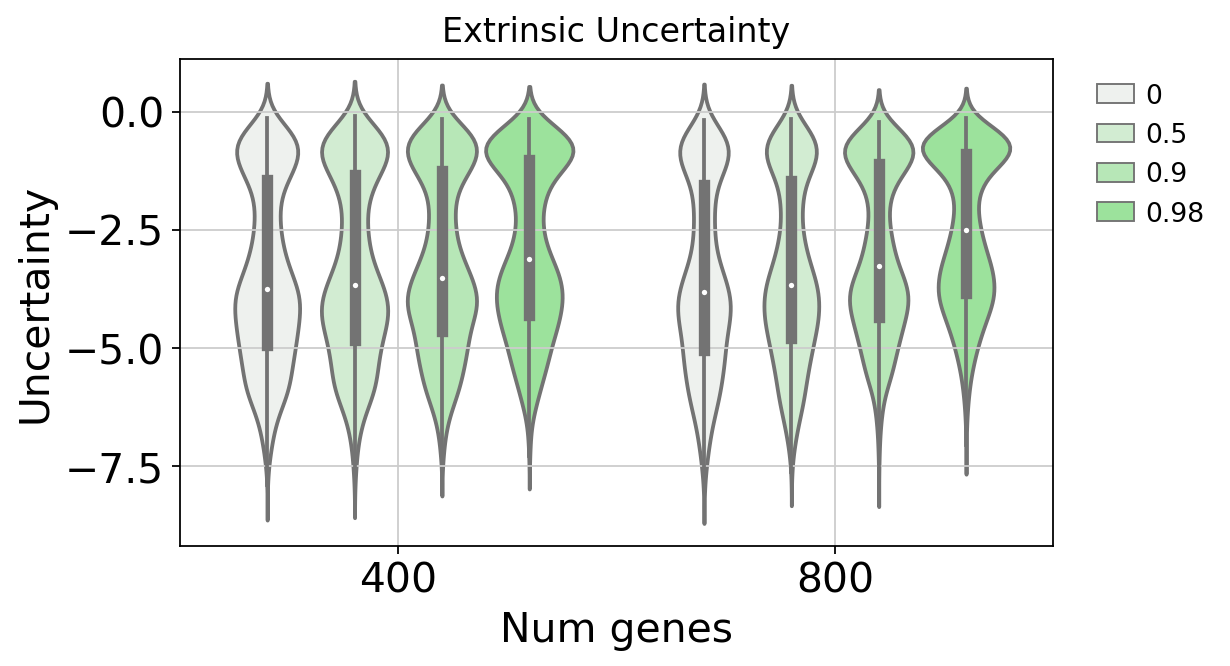

In [19]:
pairs= [(0, 0.5), (0.5, 0.9)]
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
with mplscience.style_context():
    x = "Num genes"
    y = "Uncertainty"
    hue = "Dropout probability"
    df = uncertainty_full_df.query("Type == 'Intrinsic'")
    sns.violinplot(x=x, y=y, hue=hue, data=df, color="lightblue", ax=ax)
    plt.title("Intrinsic Uncertainty")
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
    # annotator = Annotator(ax, pairs, data=df, x=x, y=y)
    # annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
    # annotator.apply_and_annotate()
    ax.grid()

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'uncertainty' / 'pancreas_noise' / 'intrinsic_dropout.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )    


fig, ax = plt.subplots(1, 1, figsize=(7, 4))
with mplscience.style_context():
    df = uncertainty_full_df.query("Type == 'Extrinsic'")
    sns.violinplot(x=x, y=y, hue=hue, data=df, color="lightgreen", ax=ax)
    plt.title("Extrinsic Uncertainty")
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
    # annotator = Annotator(ax, pairs, data=df, x=x, y=y)
    # annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
    # annotator.apply_and_annotate()
    ax.grid()

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'uncertainty' / 'pancreas_noise' / 'extrinsic_dropout.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )        

Fam135a


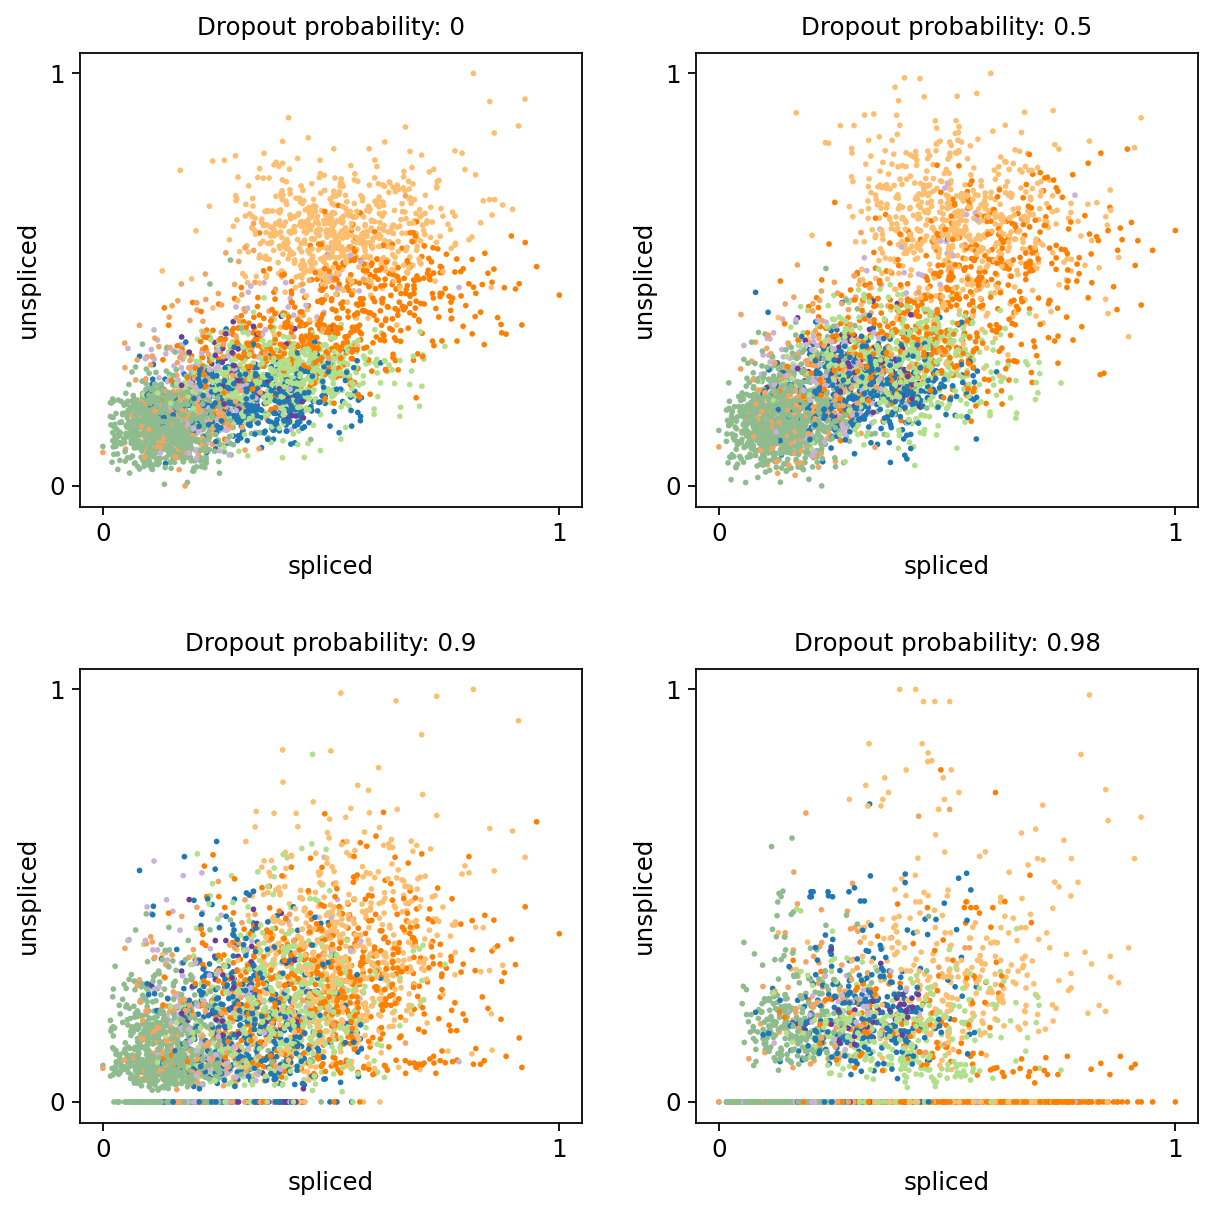

In [20]:
g = perturbed_adatas[(0.1, 800)].var.query("scaled_gene == True").index[3]
print(g)
fig, axarr = plt.subplots(2, 2, figsize=(8, 8))
with mplscience.style_context():
    for s, ax in zip(sorted(fracs)[::-1], axarr.flat):
        ad = perturbed_adatas[(s, 800)]
        scv.pl.scatter(ad, basis=g, title=f"Dropout probability: {1 - s}", ax=ax, show=False)
plt.tight_layout()

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'uncertainty' / 'pancreas_noise' / 'genes_dropout.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )    



## Multiplicative noise

In [21]:
adata = scv.datasets.pancreas(DATA_DIR / "pancreas" / "endocrinogenesis_day15.h5ad")


In [22]:
scales = [0.1, 0.5, 1, 1.5]
uncertainty_full_df = pd.DataFrame(columns=["Uncertainty", "Noise scale", "Type", "Cell type"])
perturbed_adatas = {}
adata.obs["dummy"] = "dummy"
ct = "dummy"
for s in scales:
    if s != 0 or s != 1:
        bdata = add_noise_to_celltype(adata, "dummy", ct, s, genes_to_use=genes_to_use)
    else:
        bdata = adata.copy()
    bdata = preprocess_data(bdata, min_max_scale=True, filter_on_r2=False)
    perturbed_adatas[s] = bdata
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")
    vae = VELOVI(bdata)
    vae.train()
    uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=100)
    extrinsic = np.log10(compute_extrinisic_uncertainty(bdata, vae, n_samples=25)).values
    intrinsic = np.log10(uncertainty_df.directional_cosine_sim_variance).values
    unc_type = ["Intrinsic"] * len(intrinsic) + ["Extrinsic"] * len(extrinsic)
    df = pd.DataFrame()
    df["Uncertainty"] = np.concatenate([intrinsic, extrinsic])
    df["Noise scale"] = [s] * len(df)
    df["Type"] = unc_type
    df["Cell type"] = np.concatenate([bdata.obs.clusters.values, bdata.obs.clusters.values])
    uncertainty_full_df = pd.concat([uncertainty_full_df, df])

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 464/500:  93%|█████████▎| 464/500 [01:24<00:06,  5.50it/s, loss=-2.39e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2318.713. Signaling Trainer to stop.
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 3612 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    2.9s finished


Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:05<02:03,  5.14s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:10<01:56,  5.05s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:15<01:52,  5.12s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:20<01:49,  5.19s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:25<01:44,  5.22s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:31<01:38,  5.20s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:36<01:32,  5.15s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:41<01:26,  5.12s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:46<01:22,  5.17s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:51<01:18,  5.21s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [00:56<01:10,  5.03s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [01:01<01:06,  5.09s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:07<01:02,  5.21s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:12<00:57,  5.22s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:17<00:52,  5.22s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:22<00:45,  5.07s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [01:27<00:41,  5.15s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [01:31<00:34,  4.86s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [01:36<00:29,  4.95s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [01:41<00:24,  4.91s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [01:46<00:19,  4.92s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [01:52<00:15,  5.04s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [01:55<00:09,  4.52s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [02:00<00:04,  4.69s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [02:05<00:00,  5.02s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2371 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.9s finished


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [01:28<00:00,  5.62it/s, loss=-2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [01:28<00:00,  5.62it/s, loss=-2.4e+03, v_num=1]
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 3597 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    2.9s finished


Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:05<02:21,  5.90s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:12<02:26,  6.36s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:18<02:19,  6.33s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:25<02:15,  6.47s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:32<02:09,  6.47s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:38<02:04,  6.54s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:45<01:58,  6.58s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:52<01:52,  6.61s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:58<01:45,  6.60s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [01:04<01:37,  6.51s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [01:11<01:29,  6.41s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [01:17<01:22,  6.38s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:21<01:09,  5.80s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:28<01:05,  5.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:34<01:00,  6.01s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:40<00:54,  6.05s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [01:45<00:46,  5.79s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [01:51<00:40,  5.80s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [01:55<00:32,  5.41s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [02:01<00:27,  5.54s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [02:07<00:22,  5.64s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [02:14<00:17,  5.87s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [02:20<00:11,  5.96s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [02:26<00:05,  5.92s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [02:30<00:00,  6.02s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.9s finished


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 345/500:  69%|██████▉   | 345/500 [01:01<00:27,  5.64it/s, loss=-2.56e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2462.855. Signaling Trainer to stop.
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 3597 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    3.0s finished


Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:06<02:39,  6.63s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:12<02:27,  6.41s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:18<02:12,  6.03s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:25<02:10,  6.23s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:30<02:02,  6.14s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:37<02:00,  6.33s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:44<01:54,  6.38s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:50<01:47,  6.30s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:56<01:41,  6.33s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [01:03<01:35,  6.36s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [01:06<01:18,  5.59s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [01:13<01:17,  5.98s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:20<01:14,  6.19s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:26<01:07,  6.17s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:32<01:01,  6.20s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:39<00:56,  6.28s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [01:45<00:50,  6.31s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [01:52<00:44,  6.34s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [01:55<00:33,  5.54s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [02:01<00:28,  5.71s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [02:08<00:24,  6.00s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [02:15<00:18,  6.17s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [02:22<00:12,  6.41s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [02:27<00:06,  6.24s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [02:34<00:00,  6.17s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2371 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.8s finished


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 277/500:  55%|█████▌    | 277/500 [00:50<00:40,  5.51it/s, loss=-3e+03, v_num=1]   
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2877.767. Signaling Trainer to stop.
INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 3612 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    2.9s finished


Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:05<02:12,  5.52s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:13<02:37,  6.85s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:19<02:25,  6.63s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:27<02:27,  7.04s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:35<02:25,  7.27s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:42<02:20,  7.37s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:49<02:11,  7.30s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:57<02:06,  7.47s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [01:05<02:00,  7.54s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [01:10<01:44,  6.96s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [01:18<01:40,  7.18s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [01:26<01:36,  7.40s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [01:33<01:28,  7.41s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [01:39<01:13,  6.72s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [01:47<01:11,  7.15s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [01:54<01:03,  7.04s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [02:01<00:57,  7.17s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [02:09<00:51,  7.38s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [02:17<00:44,  7.47s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [02:24<00:37,  7.53s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [02:32<00:29,  7.48s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [02:39<00:22,  7.57s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [02:47<00:15,  7.55s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [02:54<00:07,  7.48s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [03:02<00:00,  7.29s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2398 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.9s finished


### Plot

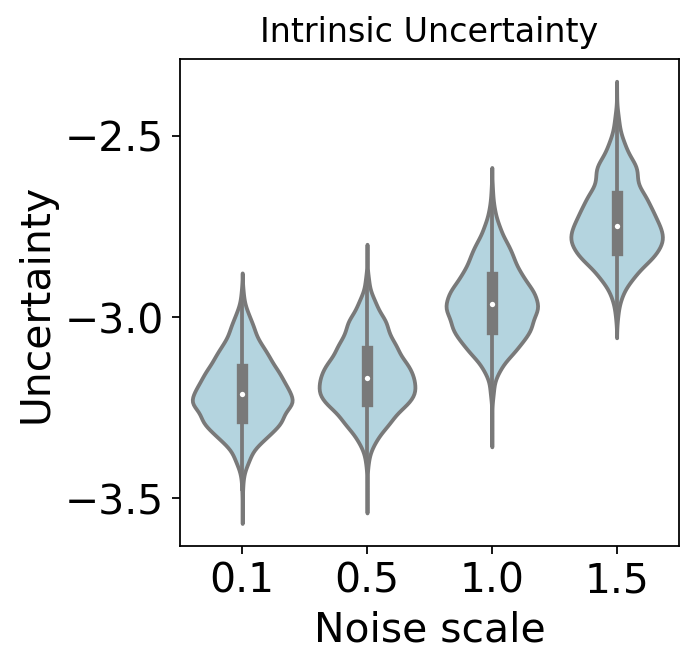

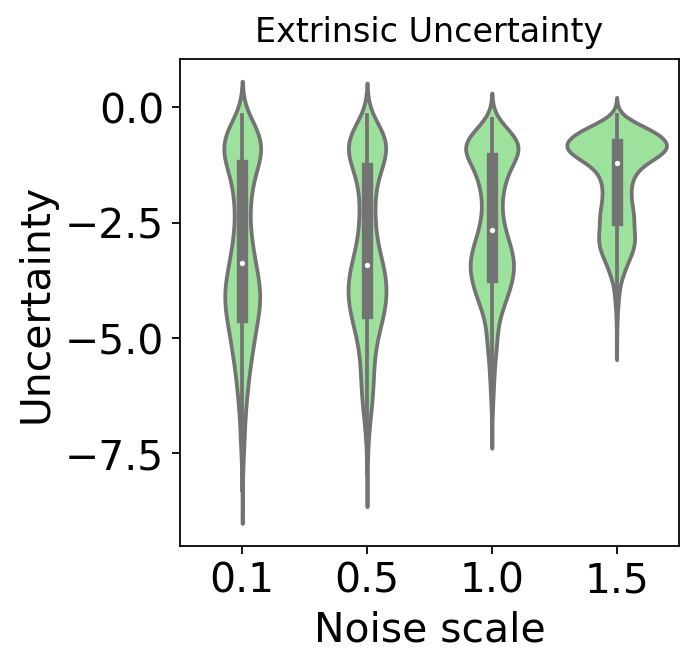

In [23]:
pairs= [(0, 0.25), (0.25, 0.5),(0.5, 0.75)]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
with mplscience.style_context():
    x = "Noise scale"
    y = "Uncertainty"
    df = uncertainty_full_df.query("Type == 'Intrinsic'")
    sns.violinplot(x=x, y=y, data=df, color="lightblue", ax=ax)
    plt.title("Intrinsic Uncertainty")
    # annotator = Annotator(ax, pairs, data=df, x=x, y=y)
    # annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
    # annotator.apply_and_annotate()

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'uncertainty' / 'pancreas_noise' / 'intrinsic_multiplicative.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )        

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
with mplscience.style_context():
    df = uncertainty_full_df.query("Type == 'Extrinsic'")
    sns.violinplot(x=x, y=y, data=df, color="lightgreen", ax=ax)
    plt.title("Extrinsic Uncertainty")
        # annotator = Annotator(ax, pairs, data=df, x=x, y=y)
        # annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
        # annotator.apply_and_annotate()

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'uncertainty' / 'pancreas_noise' / 'extrinsic_multiplicative.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )            

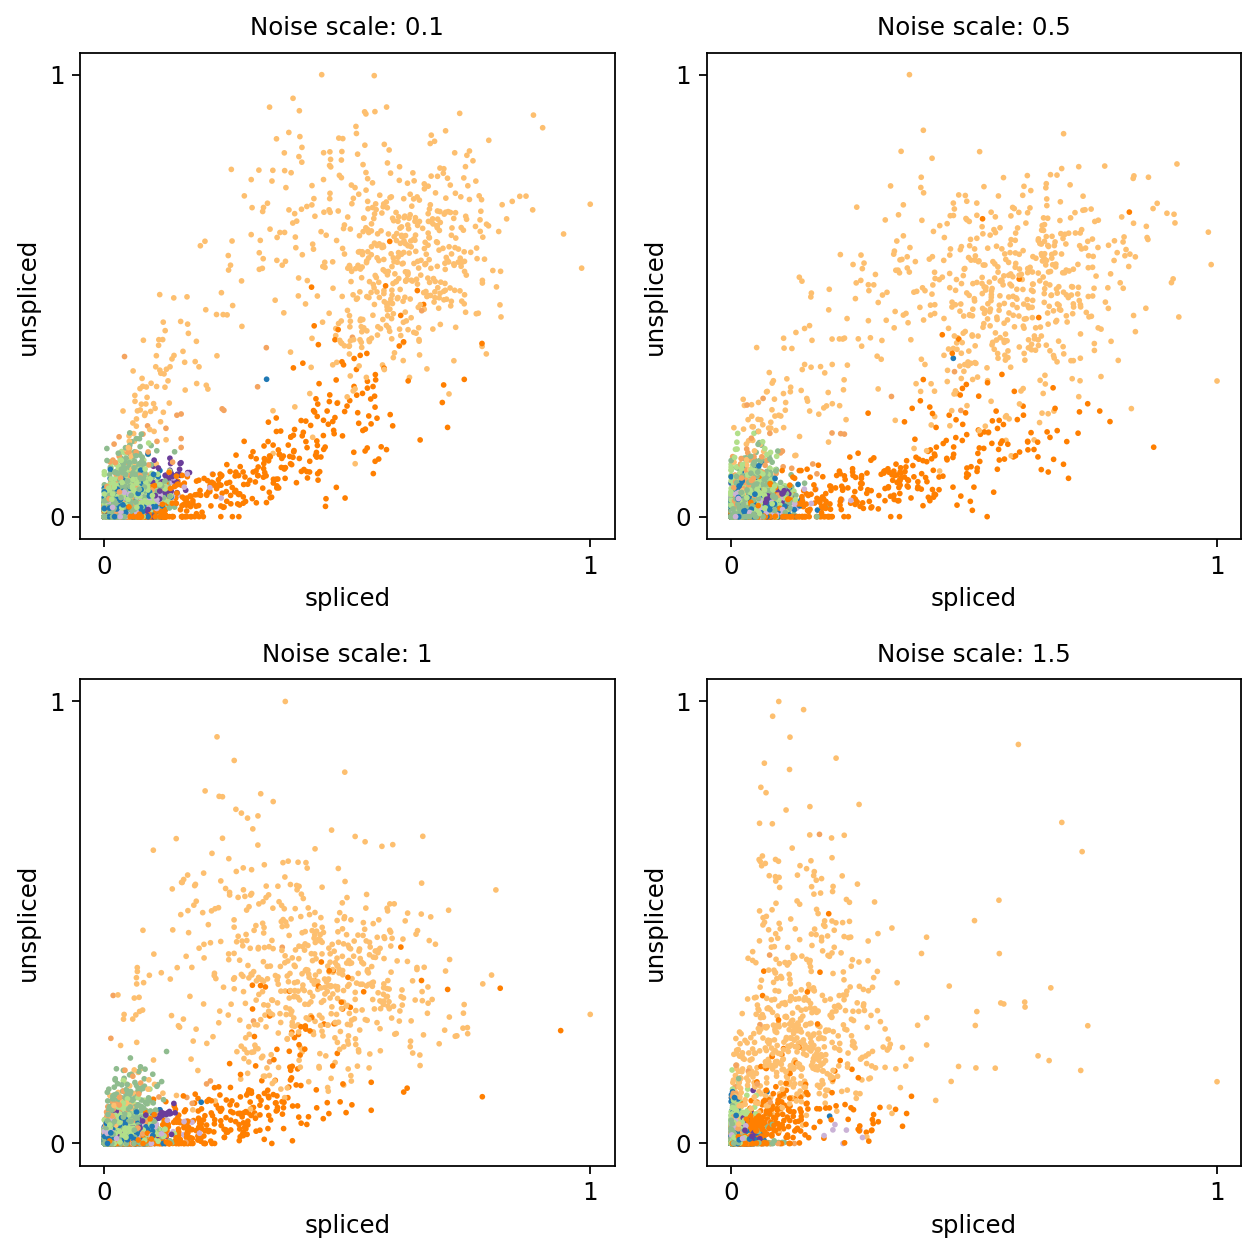

In [24]:
g = "Sulf2"
fig, axarr = plt.subplots(2, 2, figsize=(8, 8))
with mplscience.style_context():
    for (s, ad), ax in zip(perturbed_adatas.items(), axarr.flat):
        scv.pl.scatter(ad, basis=g, title=f"Noise scale: {s}", ax=ax, show=False)
    plt.tight_layout()

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'uncertainty' / 'pancreas_noise' / 'genes_multiplicative.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )    
